In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import mido
from utils.midi_tools02 import mid2arry, convert2binary, arry2mid
from utils.data_processing import get_tonnetz_edge_index, slice_temporal_data

c:\Users\mange\miniconda3\envs\music-gnn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper functions

## MIDI processing functions

In [2]:
def get_midi_timesteps(filename):
    midi = mido.MidiFile(filename)
    timesteps = 0
    for track in midi.tracks:
        for msg in track:
            timesteps += msg.time
    return timesteps

def midi_to_tensor(filename, binary_velocity=False):
    mid = mido.MidiFile(filename)
    # Extract information about the notes being played
    max_timesteps = get_midi_timesteps(filename)
    tensor = np.zeros((max_timesteps, 128))
    previous_note = [0] * 128
    timesteps = 0
    for track in mid.tracks:
        for msg in track:
            timesteps += msg.time
            if msg.type == 'note_on':
                tmp = previous_note[msg.note]
                tensor[tmp:timesteps, msg.note] = tensor[tmp, msg.note]
                if binary_velocity:
                  tensor[timesteps, msg.note] = 1 if msg.velocity > 0 else 0
                else:
                  tensor[timesteps, msg.note] = msg.velocity
                previous_note[msg.note] = timesteps
            if msg.type == 'note_off':
                tmp = previous_note[msg.note]
                tensor[tmp:timesteps, msg.note] = tensor[tmp, msg.note]
                tensor[timesteps, msg.note] = 0
                previous_note[msg.note] = timesteps
    return torch.from_numpy(tensor)

def arry2mid(ary, tempo=500000):
    new_ary = np.concatenate([np.array([[0] * 128]), np.array(ary)], axis=0)
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    changes = new_ary[1:] - new_ary[:-1]
    last_time = 0
    for ch in changes:
        if sum(ch) == 0:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_velocity = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_velocity):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=int(n), velocity=int(v), time=int(new_time)))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=int(n), velocity=0, time=int(new_time)))
                first_ = False
            last_time = 0
    return mid_new

## Tonnetz Adjancy matrix generating function

In [3]:
# In Tonnetz, each node has six neighbours which have pitches of the following distances (in semi-tones)
# E.g. C4 has neighbours F3, G#3, A3, D#4, E4, G4
NEIGHBOUR_DISTANCES = [-7, -4, -3, 3, 4, 7]

def create_tonnetz_adjacency_matrix(num_notes):
  A = []

  for i in range(num_notes):
    row = torch.zeros(num_notes, dtype=torch.int)
    for d in NEIGHBOUR_DISTANCES:
      j = i+d
      if j >= 0 and j < num_notes:
        row[j] = 1
    A.append(row)
  return torch.stack(A)

def get_edge_attributes(A):
  # Returns edge attributes for the adjacency matrix `A`, 
  # where the edge attributes are a one-hot encoding for each type of edge
  edge_index = A.to_sparse().indices()
  edge_attr_raw = []
  for i in range(edge_index.shape[1]):
    distance = (edge_index[1][i] - edge_index[0][i]).item()
    edge_attr_raw.append(NEIGHBOUR_DISTANCES.index(distance))
  return F.one_hot(torch.tensor(edge_attr_raw))

## Data processing helper function

In [4]:
import math, logging

def calculate_compress_factor(file_name, desired_tpb):
  mid = mido.MidiFile(file_name)
  compress_factor = mid.ticks_per_beat / desired_tpb
  if compress_factor % 1.0 != 0.0:
    logging.warning(f"compress_factor of {compress_factor} is not an integer, rounding up...")
  compress_factor = math.ceil(compress_factor)
  return compress_factor

def compress_tensor(tensor, file_name, method, desired_tpb=16):
  '''
  Reduces the fidelity of the musical tensor, i.e. merge multiple timesteps into one step

  Args:
    `tensor`: PyTorch tensor of shape (timesteps, num_notes)
    `file_name`: path to the MIDI file
    `method`: str in ["max", "avg", "majority"]
    `desired_tpb`: desired ticks per beat for the tensor to be compressed to
  '''
  tensor_np = tensor.cpu().detach().cpu()
  assert(len(tensor_np.shape) == 2)

  compress_factor = calculate_compress_factor(file_name, desired_tpb)
  compressed_vectors = []
  length = tensor_np.shape[0]
  for start in range(0, length, compress_factor):
    end = min(start + compress_factor, length)
    tensor_slice = tensor_np[start:end, :]
    if (method == "max"):
      raise NotImplementedError()
    elif (method == "avg"):
      raise NotImplementedError()
    elif (method == "majority"):
      majority = (end-start) / 2
      majority_nonzeroes = np.count_nonzero(tensor_slice, axis=0) >= majority
      compressed_vectors.append((majority_nonzeroes).astype(int))
    else:
      raise KeyError(f"Unknown method {method}")
  return torch.tensor(np.array(compressed_vectors))

def reduce_tensor(tensor, start_note, end_note):
  '''
  Args:
    `tensor`: PyTorch tensor of shape (timesteps, num_notes)
    `start_note`: note to start the tensor from (integer in 0-127)
    `end_note`: note to end the tensor at (integer in 0-127)
  '''
  assert(end_note >= start_note)
  return tensor[:, start_note:end_note+1]

def uncompress_tensor(tensor, orig_tpb, compressed_tpb):
  '''
  Args:
    `tensor`: PyTorch tensor of shape (timesteps, num_notes)
    `orig_tpb`: ticks per beat of the original/generated MIDI file
    `compressed_tpb`: ticks per beat used by the compressed `tensor`
  '''
  compress_factor = orig_tpb / compressed_tpb
  if compress_factor % 1.0 != 0.0:
    logging.warning(f"compress_factor of {compress_factor} is not an integer, rounding up...")
  compress_factor = math.ceil(compress_factor)
  # "Stretch" out the tensor using Kronecker product
  return torch.kron(tensor, torch.ones((compress_factor, 1)))

def unreduce_tensor(tensor, start_note, end_note):
  '''
  Expands out a reduced tensor to include all 128 notes in the MIDI range

  Args:
    `tensor`: PyTorch tensor of shape (timesteps, num_notes)
    `start_note`: MIDI note that `tensor` starts from (integer in 0-127)
    `end_note`: MIDI note that `tensor` ends at (integer in 0-127)
  '''
  assert(end_note >= start_note)
  timesteps = tensor.shape[0]
  low_notes = torch.zeros((timesteps, start_note))
  high_notes = torch.zeros((timesteps, 127-end_note))
  return torch.cat((low_notes, tensor.to("cpu"), high_notes), dim=1)

In [5]:
# function which takes music sequence and window size(history length) and return training data.
# music = Time_step x Num_nodes
def slice_temporal_data(music_seq,window_size=5):
  return [[torch.transpose(music_seq[i:i+window_size],0,1),music_seq[i+window_size].reshape(-1,1)] for i in range(len(music_seq)-window_size)]

# Data loading

In [6]:
# Download and extract piano MIDI files from Maestro
import os
dir_to_scan = "data/2013"
directory_files = os.listdir(dir_to_scan)
data_files = []
for file in directory_files:
  data_files.append(os.path.join(dir_to_scan, file))
print(data_files[:10])

['data/2013\\ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_02_R3_2013_wav--1.midi', 'data/2013\\ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--1.midi', 'data/2013\\ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--2.midi', 'data/2013\\ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--3.midi', 'data/2013\\ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--1.midi', 'data/2013\\ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--2.midi', 'data/2013\\ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--3.midi', 'data/2013\\ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--1.midi', 'data/2013\\ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--2.midi', 'data/2013\\ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--3.midi']


In [7]:
desired_tpb = 8

num_files = 10
window_size = desired_tpb * 4
start_note = 33
end_note = 96

train_data = []
for i, data_file in enumerate(data_files):
  midi_tensor = midi_to_tensor(data_file, binary_velocity=True)
  compressed_tensor = compress_tensor(midi_tensor, data_file, "majority", desired_tpb)
  reduced_tensor = reduce_tensor(compressed_tensor, start_note, end_note)
  train_data += slice_temporal_data(reduced_tensor.to(torch.float), window_size)
  if i == num_files:
    break
print(len(train_data), train_data[0][0].shape, train_data[0][1].shape)

91419 torch.Size([64, 32]) torch.Size([64, 1])


# Prepare model trainig 

## create graph representation

In [8]:
new_num_notes = train_data[0][0].shape[0]
A = create_tonnetz_adjacency_matrix(new_num_notes)
edge_attr = get_edge_attributes(A)
print(A.shape)
print(edge_attr.shape)

torch.Size([64, 64])
torch.Size([356, 6])


## create data loader

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

data_X = torch.stack([d[0] for d in train_data])
print(data_X.shape)
y = torch.stack([d[1] for d in train_data])
data_Y = y.squeeze(-1)
print(data_Y.shape)
X_train, X_test, y_train, y_test = train_test_split(data_X.to(torch.float), data_Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_test, y_test)

batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

torch.Size([91419, 64, 32])
torch.Size([91419, 64])
torch.Size([73135, 64, 32])
torch.Size([73135, 64])


# Define the model

In [10]:
from torch_geometric_temporal.nn.recurrent import GConvLSTM

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is ",device)

Device is  cuda


## model definition

In [11]:
class SimpleSTGCN(nn.Module):
    # input_dim = dim of node features
    # output_dim = number of class which is ON/OFF
    def __init__(self, adj_mat, edge_attrs, input_dim, hidden_dim=16, output_dim=2):
        super(SimpleSTGCN, self).__init__()
        self.adj_mat = adj_mat
        self.edge_index = self.adj_mat.to_sparse().indices().to(device)
        self.edge_weight = edge_attrs.to(device).to(float)
        
        # GCN layers
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.gcn_conv1 = GConvLSTM(hidden_dim,hidden_dim,K=2)   # K=2 for 2-degree convolution (neighbor convolution)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        #print(x.shape)
        h,c = self.gcn_conv1(x,self.edge_index)
        #print(h.shape, c.shape)
        x = F.relu(self.linear3(h))
        x = self.linear4(x)
        y_hat = x.squeeze(-1)
        return y_hat

In [12]:
gcn_conv1 = GConvLSTM(32,16,K=2)
edge_index = A.to_sparse().indices()
#print(edge_index)
for x,y in train_dataloader:
  print(x[0].shape)
  h,c = gcn_conv1(x[0],edge_index)
  print(h.shape,c.shape)
  break

torch.Size([64, 32])
torch.Size([64, 16]) torch.Size([64, 16])


# Create Music

## music create function

In [20]:
def generate_music_tensor(net, seed, timesteps):
  generated = seed
  window_size = seed.shape[1]
  for i in range(timesteps):
    if i == 0:
      pred = net(seed)
    else:
      pred = net(generated[:, -window_size:])
    curr = (torch.sigmoid(pred) > 0.5).float()
    generated = torch.cat((generated, curr.unsqueeze(1)), dim=1)
  return generated

def create_music(model, seed, new_timesteps, start_note, end_note, orig_tpb, compressed_tpb):
  print("generating ...")
  generated_tensor = generate_music_tensor(model, seed, new_timesteps)
  print("unreduce ...")
  generated_tensor_mod = unreduce_tensor(torch.transpose(generated_tensor, 0, 1), start_note, end_note)
  print("uncompress ...")
  generated_tensor_mod = uncompress_tensor(generated_tensor_mod, orig_tpb, compressed_tpb)
  return generated_tensor_mod

## create music

In [17]:
new_timesteps = 3000
orig_tpb = 384
compressed_tpb = desired_tpb

net2 = SimpleSTGCN(A, edge_attr, window_size, output_dim=1)
net2.load_state_dict(torch.load("model_params/Simple_GConvLSTM_model.net"))
net2 = net2.to(device)


In [21]:

data, _ = next(iter(valid_dataloader))
seed = data[0].to(device)
generated = create_music(net2, seed, new_timesteps, start_note, end_note, orig_tpb, compressed_tpb)
print(generated.shape)

generating ...
unreduce ...
uncompress ...
torch.Size([145536, 128])


In [30]:
arr = generated.cpu().detach().numpy()
mid = arry2mid(arr,tempo=5000000)

In [31]:
mid.save("generated_music/sample_music_GConvLSTM_acc_0.4219.midi")

In [33]:
from utils.midi_tools01 import tensor_to_midi
tensor_to_midi(generated,"generated_music/sample_music_GConvLSTM_acc_0.4219.midi")

MidiFile(type=1, ticks_per_beat=384, tracks=[
  MidiTrack([
    Message('note_on', channel=0, note=76, velocity=1, time=96),
    Message('note_on', channel=0, note=83, velocity=0, time=0),
    Message('note_on', channel=0, note=76, velocity=0, time=192),
    Message('note_on', channel=0, note=82, velocity=1, time=0),
    Message('note_on', channel=0, note=82, velocity=0, time=96),
    Message('note_on', channel=0, note=67, velocity=0, time=48),
    Message('note_on', channel=0, note=74, velocity=1, time=0),
    Message('note_on', channel=0, note=69, velocity=1, time=192),
    Message('note_on', channel=0, note=73, velocity=1, time=0),
    Message('note_on', channel=0, note=74, velocity=0, time=0),
    Message('note_on', channel=0, note=76, velocity=1, time=192),
    Message('note_on', channel=0, note=73, velocity=0, time=96),
    Message('note_on', channel=0, note=76, velocity=0, time=48),
    Message('note_on', channel=0, note=77, velocity=1, time=0),
    Message('note_on', channel=0,

## Piano roll view

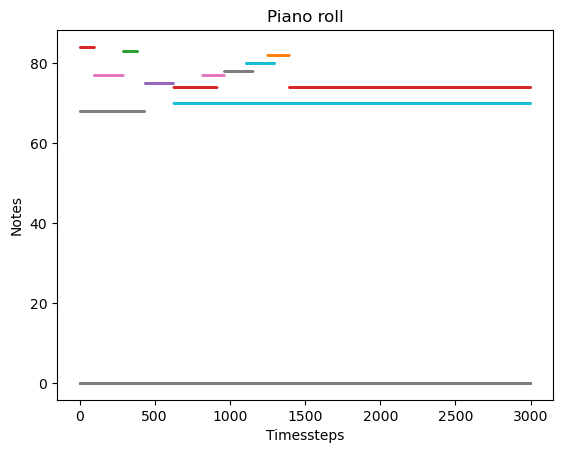

In [32]:
from utils.piano_roll_visualizer import piano_roll
piano_roll(arr)